<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/childcare_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 子育てスコア
- input
    - public_school_score.csv
        - 幼稚園スコア
    - nursery_score.csv
        - 保育園スコア
        - 児童館スコア
- output
    - childcare_score.csv
        - 子育てスコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '子育てスコア'
output_score_file = 'childcare_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID', '幼稚園スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 1)


In [8]:
df_school_score.head()

,幼稚園スコア
地域ID,
101003,2.362
101004,2.185
101005,2.143
101007,1.830
101008,2.085


### 保育園

In [9]:
df_nursery_score = pd.read_csv(os.path.join(DIR_NAME, 'nursery_score.csv'))[[
    '地域ID', '保育園スコア', '児童館スコア'
]].set_index('地域ID')
print(df_nursery_score.shape)

(3145, 2)


In [10]:
df_nursery_score.head()

,保育園スコア,児童館スコア
地域ID,,
101003,1.049,1.383
101004,0.968,1.144
101005,1.053,1.204
101007,1.182,1.352
101008,1.220,1.615


In [11]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    rank = sr_data.rank()
    count = rank.max() 
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

### 子育てスコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_nursery_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 6)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 6)


,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア
地域ID,,,,,,
101003,千代田区,丸の内,丸の内１丁目,2.362,1.049,1.383
101004,千代田区,丸の内,丸の内２丁目,2.185,0.968,1.144
101005,千代田区,丸の内,丸の内３丁目,2.143,1.053,1.204
101007,千代田区,大手町,大手町１丁目,1.830,1.182,1.352
101008,千代田区,大手町,大手町２丁目,2.085,1.220,1.615


In [14]:
feature_list = {
    '幼稚園スコア': {'sort': 1, 'weight': 1},
    '保育園スコア': {'sort': 1, 'weight': 1},
    '児童館スコア': {'sort': 1, 'weight': 1},
}

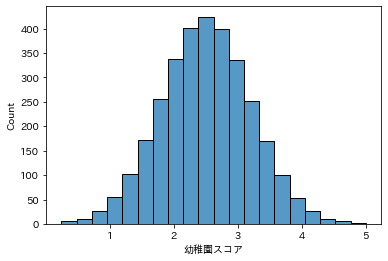

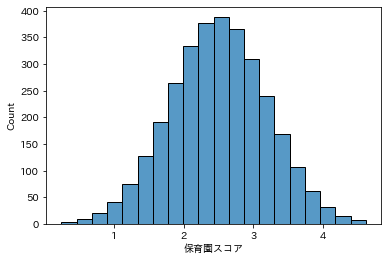

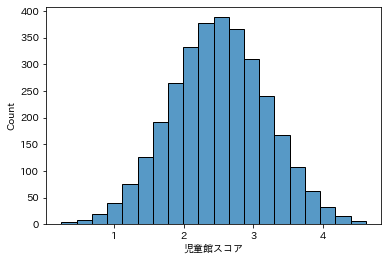

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

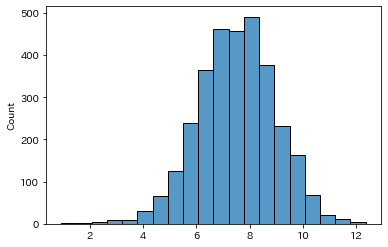

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

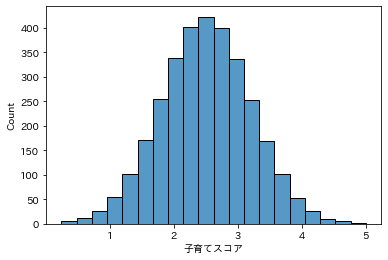

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501557
std         0.698656
min         0.244613
25%         2.028908
50%         2.500558
75%         2.972493
max         5.000000
Name: 子育てスコア, dtype: float64

In [20]:
output_score_list = list(feature_list.keys()) + [score_name]
for col in output_score_list:
    df_pop_master[col] = df_pop_master[col].round(2)

In [21]:
df_pop_master[output_score_list].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

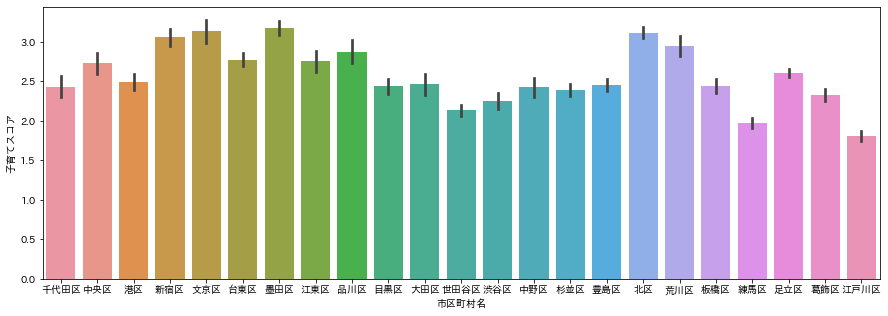

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [23]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(901, 7)


In [24]:
df_level.head(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
0,品川区,豊町,豊町４丁目,3.84,4.06,4.35,5.00
1,品川区,西大井,西大井６丁目,3.94,3.46,4.43,4.76
2,新宿区,東五軒町,東五軒町,2.99,4.12,4.49,4.67
3,文京区,本駒込,本駒込３丁目,2.77,4.30,4.46,4.56
4,文京区,水道,水道１丁目,3.60,3.80,4.18,4.52
5,北区,西が丘,西が丘２丁目,4.37,3.37,3.82,4.49
6,新宿区,津久戸町,津久戸町,4.89,3.61,2.97,4.46
7,江東区,千田,千田,4.15,3.47,3.83,4.43
8,杉並区,上荻,上荻１丁目,2.16,4.33,4.57,4.41
9,新宿区,中町,中町,3.50,3.80,4.01,4.39


In [25]:
df_level.tail(10)

,市区町村名,町名,町丁目,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
891,千代田区,霞が関,霞が関３丁目,1.88,0.94,1.56,1.06
892,江戸川区,堀江町,堀江町,2.23,1.63,0.48,1.02
893,千代田区,日比谷公園,日比谷公園,2.19,0.88,1.13,0.94
894,世田谷区,砧公園,砧公園,1.18,1.22,1.59,0.88
895,千代田区,皇居外苑,皇居外苑,1.96,0.86,1.07,0.85
896,江東区,若洲,若洲１丁目,2.54,0.57,0.76,0.84
897,大田区,東海,東海１丁目,1.64,0.88,1.23,0.82
898,大田区,京浜島,京浜島１丁目,1.37,0.91,1.18,0.77
899,大田区,羽田空港,羽田空港１丁目,1.13,0.99,1.27,0.74
900,大田区,城南島,城南島１丁目,1.39,0.67,0.80,0.59
